In [1]:
from openpyxl.reader.excel import load_workbook
import pandas as pd 
import numpy as np
from itertools import islice
from openpyxl.utils import FORMULAE
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Color, PatternFill, Font, Border, Side
from openpyxl.formatting.rule import ColorScaleRule, CellIsRule, FormulaRule
import statistics
from openpyxl.chart import (ScatterChart, Reference, Series)
import matplotlib.pyplot as plt
from openpyxl.chart.trendline import Trendline
import openpyxl
from openpyxl.drawing.image import Image
from openpyxl.styles import Font
#from openpyxl.styles import Color, PatternFill, Font, Border

In [2]:
# wb = load_workbook('sample.xlsx')

filename = 'sample.xlsx'
wb = load_workbook(filename)
ws = wb['Sheet1']

#create df of plate map
samp = ws.values
columns = next(samp)[1:]
samp = list(samp)
idx = [r[0] for r in samp]
samp = (islice(r, 1, None) for r in samp)
df = pd.DataFrame(samp, index=idx, columns=columns)

#create df of raw data values
ws2 = wb['Sheet2']

data = ws2.values
columns = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df2 = pd.DataFrame(data, index=idx, columns=columns)

print(df, '\n', df2)

                      1            2            3            4            5   \
A                     S1           S2           S3           S4           S5   
B                     S1           S2           S3           S4           S5   
C                    S13          S14          S15          S16          S17   
D                    S13          S14          S15          S16          S17   
E                    S25          S26          S27          S28          S29   
F                    S25          S26          S27          S28          S29   
G                      A            B            C            D            E   
H                      A            B            C            D            E   
NaN                 None         None         None         None         None   
NaN                    1            2            3            4            5   
Raw Data            None         None         None         None         None   
A               0.700000     0.600000   

In [3]:
#find position of specific value in df

def findPosInDf(dfIn,findme):
    positions = []
    irow =0
    while ( irow < len(dfIn.index)):
        list_colPositions=dfIn.columns[dfIn.iloc[irow,:]==findme].tolist()   
        if list_colPositions != []:
            colu_iloc = dfIn.columns.get_loc(list_colPositions[0])
            positions.append([irow  , colu_iloc ])
        irow +=1

    return positions


#print(findPosInDf(df, 'I'))

bgPos = findPosInDf(df, 'I')

#loop to give value at every position of 'I'
value = []
for x in bgPos:  
    value.append(df2.iat[x[0],x[1]]) #returns all values for I
   
#print(value)


In [4]:
#avg all bgPos values from loop

def avg(value):
    return sum(value) / len(value)

avg(value)
bgAvg = avg(value)

In [5]:
#paste df2 under df in first excel sheet

rows = dataframe_to_rows(df2)

for r_idx, row in enumerate(rows, 11):
    for c_idx, value in enumerate(row, 1):
        ws.cell(row=r_idx, column=c_idx, value=value)


In [6]:
#input table titles into excel
ws['A1'] = 'Plate Map'
ws['A12'] = 'Raw Data'

ws['A22'] = 'Avg BG:'
ws['B22'] = bgAvg

ws['A24'] = 'BG Subtract'

ws['A33'] = 'Mean Std:'
ws['A34'] = 'ug/ml:'

ws['A38'] = 'ug/ml:'

ws['A49'] = 'ug/ml x DF:'
wb.save(filename)

In [7]:
#format border around cells

In [8]:
#subtract bgAvg from all df2 cells
s = 0
subData = []
for s in df2:
    subData = df2 - bgAvg
    s+=1
#print(subData)


In [9]:
#paste subtracted data into excel
rows = dataframe_to_rows(subData)

for r_idx, row in enumerate(rows, 23):
    for c_idx, value in enumerate(row, 1):
        ws.cell(row=r_idx, column=c_idx, value=value)

wb.save(filename)

In [10]:
#identify standards 

stA = findPosInDf(df, 'A')
stB = findPosInDf(df, 'B')
stC = findPosInDf(df, 'C')
stD = findPosInDf(df, 'D')
stE = findPosInDf(df, 'E')
stF = findPosInDf(df, 'F')
stG = findPosInDf(df, 'G')
stH = findPosInDf(df, 'H')

stAll = [stA, stB, stC, stD, stE, stF, stG, stH]  #list of all std positions


In [11]:
stSep = []

for x in stAll: #isolates 1st std replicates from all std list
    stSep.append(x[0])
    std1 = []
    for x in stSep: #gets value of replicate 1 from bg subtracted data 
       std1.append(subData.iat[x[0],x[1]])
       
print(std1)
   
        
stSep2 = []

for x in stAll: #isolates 2ns std replicates from all std list
    stSep2.append(x[1])
    std2 = []
    for x in stSep2: #gets value of replicate 2 from bg subtracted data 
       std2.append(subData.iat[x[0],x[1]])
       
print(std2)

[1.8551, 1.4045999999999998, 0.8961, 0.6940999999999999, 0.46260000000000007, 0.22310000000000002, 0.1286, 0.031100000000000003]
[1.8768, 1.3936, 0.9056, 0.6658999999999999, 0.5065999999999999, 0.22350000000000003, 0.1436, 0.04609999999999999]


In [12]:
#mean value for each std
a = std1
b = std2
avgStd = [statistics.mean(k) for k in zip(a, b)]
print(avgStd)

[1.86595, 1.3990999999999998, 0.9008499999999999, 0.6799999999999999, 0.48460000000000003, 0.22330000000000003, 0.1361, 0.038599999999999995]


In [13]:
#put list of std means into excel
row = 33

for i, value in enumerate(avgStd):
    ws.cell(column=i+2, row=row, value=value)
wb.save(filename)

In [14]:
#put known std values into excel
stKnownVal = [2000, 1500, 1000, 750, 500, 250, 125, 50]

row = 34

for i, value in enumerate(stKnownVal):
    ws.cell(column=i+2, row=row, value=value)
wb.save(filename)

In [15]:
#std curve scatterplot

 
#chart = ScatterChart() 
  
# create data for plotting 
#xvalues = Reference(ws, min_col = 2, 
   #                 max_col = 9, min_row = 34) 
                      
#yvalues = Reference(ws, min_col = 2, 
  #                  max_col = 9, min_row = 33) 
                      
#size = Reference(ws, min_col = 3, 
 #                min_row = 2, max_row = 5) 
  
# create a 1st series of data 
#series = Series(values = yvalues, xvalues = xvalues, 
    #                  zvalues = size, title ="Std Curve") 
  
# add series data to the chart object 
#chart.series.append(series) 
  
# set the title of the chart 
#chart.title = "Std Curve "
  
# set the title of the x-axis 
#chart.x_axis.title = " Mean Abs "
  
# set the title of the y-axis 
#chart.y_axis.title = " ug/ml Protein "


# add chart to the sheet 
# the top-left corner of a chart 
# is anchored to cell E2 . 
#ws.add_chart(chart, "B40") 

  
# save the file 
#wb.save(filename) 

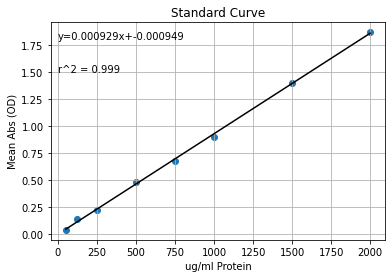

In [16]:
y = avgStd  #identify data to plot
x = stKnownVal

plt.scatter(x,y) #make scatter plot
plt.xlabel('ug/ml Protein')
plt.ylabel('Mean Abs (OD)')
plt.title('Standard Curve')

z = np.polyfit(x, y, 1)  #make trendline
p = np.poly1d(z)
plt.plot(x,p(x),"black")
plt.text(1, 1.8, "y=%.6fx+%.6f"%(z[0],z[1]))  #display trendline equation under title
m = z[0] #slope
b = z[1] #y-intercept

correlation_matrix = np.corrcoef(x, y) #find r^2 value
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

roundRSq = "{0:.3g}".format(r_squared) #round to 3 sig figs
#print(roundRSq)

plt.text(1,1.5, 'r^2 = '+ roundRSq) #add r^2 text to plot
plt.grid(True)

plt.savefig('stCurve.png') #save plot as img
plt.show()

img = Image('stCurve.png')
img.ancher = ws['O25']
ws.add_image(img, 'O25') #add plot img to excel

wb.save(filename)






In [17]:
#calculate ug/ml from subData
#subData = y --> find x (ug/ml) --> (y-b)/m = x

def getConc(y):
    conc = (y-b) / m
    return conc

concData = getConc(subData) #ug/ml in each sample


In [18]:
#put sample conc into excel

rows = dataframe_to_rows(concData)

for r_idx, row in enumerate(rows, 37):
    for c_idx, value in enumerate(row, 1):
        ws.cell(row=r_idx, column=c_idx, value=value)
        
wb.save(filename)

In [19]:
#multiply sample conc by dilution factor

dilFactor = 2.5

def getFinalConc(x):
    finalConc = x*2.5
    return finalConc

finalConc = getFinalConc(concData) #final sample conc
print(finalConc)

            1            2            3            4            5   \
A  1627.018179  1357.889072   819.630860   281.372647  1357.889072   
B  1896.147285  2246.015123   900.369592   389.024290  2246.015123   
C  2972.663711  4049.180136  3241.792817  4049.180136  3241.792817   
D  3780.051030  2972.663711  3510.921923  4049.180136  2434.405498   
E          NaN          NaN          NaN          NaN          NaN   
F          NaN          NaN          NaN          NaN          NaN   
G  4995.168945  3782.742321  2414.220815  1870.580020  1247.546139   
H  5053.569961  3753.138119  2439.788080  1794.685612  1365.962946   

            6            7            8            9            10  \
A    12.243541  2407.492587  1627.018179  2246.015123  2084.537660   
B    12.243541  2515.144230  2138.363481  1923.060196   792.717949   
C  4856.567455  3241.792817  4318.309242  3322.531549  3780.051030   
D  4587.438349  3510.921923  2972.663711  3780.051030  2972.663711   
E          NaN     

In [20]:
#put final sample conc into excel

rows = dataframe_to_rows(finalConc)

for r_idx, row in enumerate(rows, 48):
    for c_idx, value in enumerate(row, 1):
        ws.cell(row=r_idx, column=c_idx, value=value)
        
wb.save(filename)

In [21]:
#set border around all cells in range
def set_border(ws, cell_range):
    thin = Side(border_style="thin", color="000000")
    for row in ws[cell_range]:
        for cell in row:
            cell.border = Border(top=thin, left=thin, right=thin, bottom=thin)

set_border(ws, 'A12:M20')
set_border(ws, 'A24:M32')
set_border(ws, 'B11:M11')
set_border(ws, 'B23:M23')
set_border(ws, 'A38:M46')
set_border(ws, 'B37:M37')
set_border(ws, 'A49:M57')
set_border(ws, 'B48:M48')

wb.save(filename)

In [22]:
#highlight cells yellow
def yellow(ws, cell_range):
    yellowFill = PatternFill(start_color='00FFFF99',
                       end_color='00FFFF99',
                       fill_type='solid')
    ws[cell_range].fill = yellowFill

yellowList = ['A1', 'A12', 'A22', 'A24', 'A33', 'A34', 'A38', 'A49']

for x in yellowList:
    yellow(ws, x)

wb.save(filename)

In [23]:
#highlight cells blue
def blue(ws, cell_range):
    blueFill = PatternFill(start_color='0099CCFF',
                       end_color='0099CCFF',
                       fill_type='solid')
    ws[cell_range].fill = blueFill
    


for x in ws['B1:M1']:
    blue
    
    
wb.save(filename)